## DQN policy evaluation

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from itertools import count
from collections import namedtuple, deque
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


env = gym.make("CartPole-v1")

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
DQN_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)

# Load the trained model weights
DQN_net.load_state_dict(torch.load("policy_net.pth", weights_only=True))


def policy_DQN(state):
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    actions = DQN_net(state)
    action = actions.max(1)[1].view(1, 1)
    return action
    

def policy_uniform(state):
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [2]:
print(torch.cuda.is_available())
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)

True


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
memory = ReplayMemory(10000)
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    # Get next actions using policy_DQN
    next_actions = torch.tensor([
        policy_DQN(state.unsqueeze(0)).item() 
        for state in non_final_next_states
    ], device=device).unsqueeze(1)

# Get Q-values for policy-selected actions
    next_q_values = policy_net(non_final_next_states)
    next_state_values[non_final_mask] = next_q_values.gather(1, next_actions).squeeze()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [5]:
import matplotlib
import matplotlib.pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_loss(show_result=False):
    plt.figure(1)
    loss_t = torch.tensor(episode_loss, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(loss_t.numpy())
    # Take 100 episode averages and plot them too
    # if len(durations_t) >= 100:
    #     means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(99), means))
    #     plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            display.display(plt.gcf())
    else:
        plt.draw()
        plt.pause(0.001)
def calculate_loss(policy_net, DQN_net):
    # Calculate the loss
    loss = 0
    for i in range(100):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        loss += F.mse_loss(policy_net(state), DQN_net(state))
    return loss / 100

<Figure size 640x480 with 0 Axes>

100%|██████████| 3/3 [00:27<00:00,  9.13s/it]

Complete


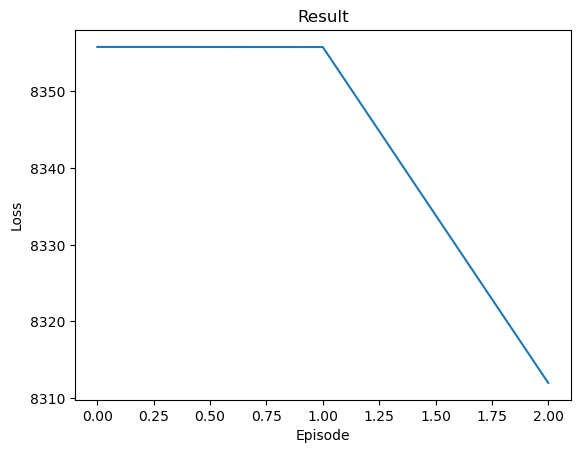

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:

num_episodes = 3
episode_loss = []
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = policy_DQN(state) # on policy evaluation
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_loss.append(calculate_loss(policy_net, DQN_net).item())
            plot_loss()
            break
    
print('Complete')
plot_loss(show_result=True)
plt.ioff()
plt.show()


In [7]:
from numpy import argmax


state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
print(DQN_net(state).argmax())
print(policy_net(state).argmax())


tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
